In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kruskal
from statsmodels.stats.multitest import fdrcorrection

from sklearn.model_selection import cross_validate

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
import sklearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score

from scipy.stats import zscore

from sklearn.pipeline import make_pipeline

import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
def select_features_kruskal_Wallis_v19(df, num_feat=6670, feat='plv', sel_feat=20):
    """Takes a df with many features. Performs Kruskal-Wallis Test. Performs FDR test.
    feat: ['plv', 'aec', 'foof', 'cc', 'pw', 'atm'] _eign _betw 
    """
    # p values for Kruskal-Wallis test
    classes = list(np.unique(df['class'].values))
    p_vals = {f'{feat}_{i}': kruskal(*[df[df['class'] == cls].iloc[:, i] 
                                for cls in classes]).pvalue for i in range(num_feat)}
    pvals = np.array(list(p_vals.values())) # num_feat p-values
    pvals_corrected = fdrcorrection(pvals)[1]
    pvals_fdr = {f'{feat}_{i}': pvals_corrected[i] for i in range(0, num_feat)}

    df_pvals_fdr = pd.DataFrame(data=np.array(list(pvals_fdr.values())).reshape((1,-1)), 
                                columns=df.columns[:-2])
    top_features_df = df_pvals_fdr.T.sort_values(by=0).T.iloc[:, :sel_feat]
    
    return (df[list(top_features_df.columns) + ['class']], df_pvals_fdr)

In [3]:
edge_datasets = ['df_plv_flat.csv', 'df_aec_flat.csv', 'df_atm.csv', 'df_cc.csv']
sel_features_40 = dict()
pvals_40 = dict()

for i, ds in enumerate(edge_datasets):
    print(f'{i}. Selecting features for {ds}')
    df = pd.read_csv("../data/flatten_datasets/" + ds)
    if ds == 'df_plv_flat.csv':
        # rename columns
        df.columns = [f'PLV_{i}-{j}' for i in range(116) for j in range(i+1, 116)] + ['ID', 'class']
        
    sel_features_40[ds], pvals_40[ds] = select_features_kruskal_Wallis_v19(df, feat=ds[3:6], num_feat=len(df.columns)-2,
                                           sel_feat=40)
    #print('Features (asc. to p-vals):\n')
    #print(list(sel_features_40[ds].columns))
    print('\n')

0. Selecting features for df_plv_flat.csv


1. Selecting features for df_aec_flat.csv


2. Selecting features for df_atm.csv


3. Selecting features for df_cc.csv




/var/folders/jd/3zpnmlfd2232jh4tlx7lspb40000gn/T/ipykernel_55533/732163257.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plv['class'] = df_plv['class'].replace('PD_off', 'PD')
/var/folders/jd/3zpnmlfd2232jh4tlx7lspb40000gn/T/ipykernel_55533/732163257.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


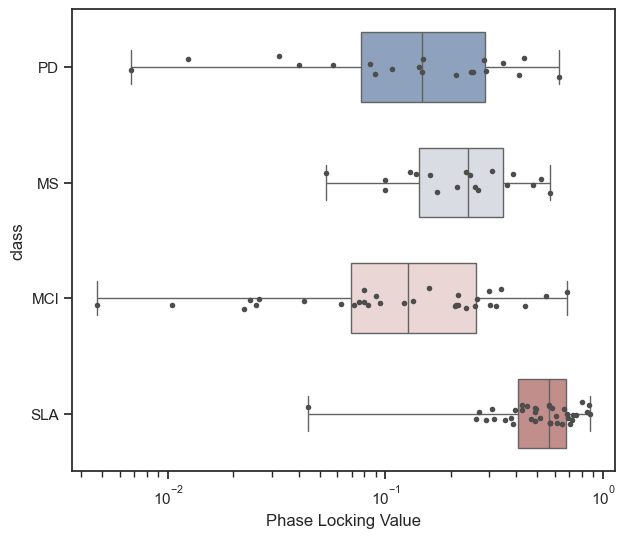

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

df_plv = sel_features_40['df_plv_flat.csv'][['PLV_45-54', 'class']]

df_plv['class'] = df_plv['class'].replace('PD_off', 'PD')

# Plot the orbital period with horizontal boxes
sns.boxplot(
    df_plv, x="PLV_45-54", y="class",# hue="method",
    whis=[0, 100], width=.6, palette="vlag"
).set(xlabel='Phase Locking Value')

sns.stripplot(df_plv, x='PLV_45-54', y='class', size=4, color='.3')

plt.savefig("../figures/boxplot_observations_600.png", dpi=600)